## Imports

In [2]:
from madgwickahrs import * 
from quaternion import Quaternion
from conversion import * 
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from scipy.stats import norm
from numpy import linalg as LA
from numpy.linalg import inv
import time
from IPython.display import Image as ImageDisp
from sympy import Symbol, symbols, Matrix, sin, cos, latex#, Plot
from sympy.interactive import printing
printing.init_printing()
%pylab inline --no-import-all


Populating the interactive namespace from numpy and matplotlib


In [3]:
dt = 0.025

# Purely Rotational Motion

## Read Files

In [4]:
trajectory_file = open("/Users/eunsunlee/Documents/NESL/UnderwaterSensorTag/IMU_GPS_Fusion/Trajectory_Simulation/simulated_measurement_from_imusim/purerotation_test_trajectory_from_imusim.txt",'r')

time = []
px = []
py = []
pz = []
vx = []
vy = []
vz = []
Ax = []
Ay = []
Az = []
 
for i in trajectory_file:
    sp = i.split()
    time.append(float(sp[0]))
    px.append(float(sp[1]))
    py.append(float(sp[2]))
    pz.append(float(sp[3]))
    vx.append(float(sp[4]))
    vy.append(float(sp[5]))
    vz.append(float(sp[6]))
    Ax.append(float(sp[7]))
    Ay.append(float(sp[8]))
    Az.append(float(sp[9]))

    
trajectory_file.close()
print(len(time))

imu_values_file = open("/Users/eunsunlee/Documents/NESL/UnderwaterSensorTag/IMU_GPS_Fusion/Trajectory_Simulation/simulated_measurement_from_imusim/purerotation_test_imu_values_from_imusim.txt",'r')

ax = []
ay = []
az = []
gx = []
gy = []
gz = []
magx = []
magy = []
magz = []

for i in imu_values_file: 
    sp = i.split()
    ax.append(float(sp[1]))
    ay.append(float(sp[2]))
    az.append(float(sp[3]))
    gx.append(float(sp[4]))
    gy.append(float(sp[5]))
    gz.append(float(sp[6]))
    magx.append(float(sp[7]))
    magy.append(float(sp[8]))
    magz.append(float(sp[9]))
    
imu_values_file.close()

368


## Visualize the trajectory from ground truth position measurement 
-  px, py, pz
-  Please note that it is equal to the trajectory in blender but depends on short_len


No handles with labels found to put in legend.


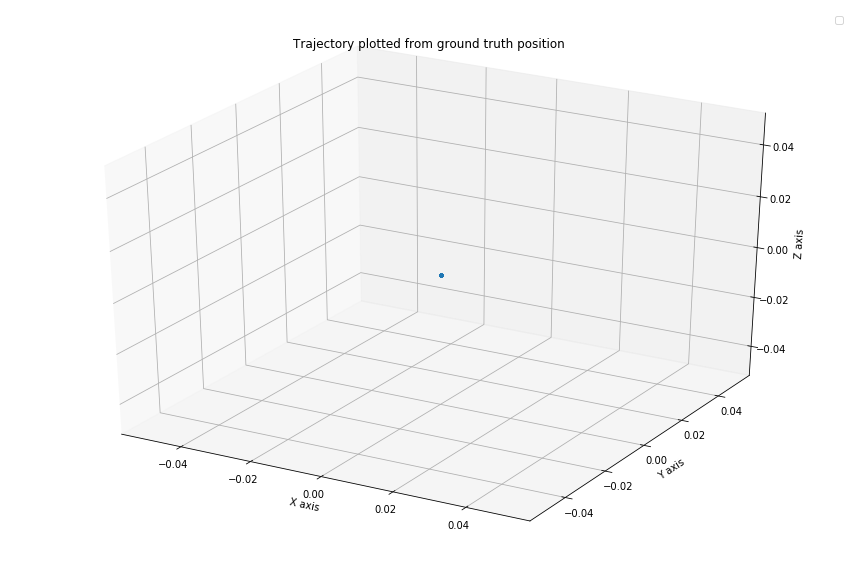

In [5]:
fig = plt.figure(figsize=(15,10))
axplot = fig.gca(projection='3d')
axplot.set_title("Trajectory plotted from ground truth position")
axplot.plot(px, py, pz, '.')
axplot.legend()
axplot.set_xlabel('X axis')
axplot.set_ylabel('Y axis')
axplot.set_zlabel('Z axis')
plt.show()

## Generate Ax, Ay, Az from ground truth IMU measurement
- This step is to verify the conept
- Ax, Ay, Az can be calculated from ax, ay, az if orientaion is given
- Initial orientation is necessary to calculate the following orientation from gyroscope
- yaw, pitch roll of an object at time[0] = ?

#### First, visualize the difference between acceleration in body frame and world frame

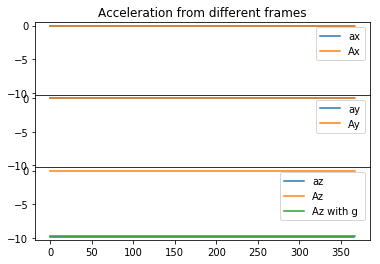

In [6]:
# Acceleration from different frames
fig, (axplot1, axplot2, axplot3) = plt.subplots(3, sharex=True, sharey=True)
axplot1.plot(ax, label='ax')
axplot1.plot(Ax, label='Ax')
axplot1.set_title('Acceleration from different frames')
axplot1.legend()
axplot2.plot(ay, label='ay')
axplot2.plot(Ay, label='Ay')
axplot2.legend()
axplot3.plot(az, label='az')
axplot3.plot(Az, label='Az')
axplot3.plot(np.array(Ax)-9.8, label='Az with g ')
axplot3.legend()
fig.subplots_adjust(hspace=0)


#### Functions needed to calculate initial orientation

In [7]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def find_R(V1, V2):
    v1_u = unit_vector(V1)
    v2_u = unit_vector(V2)
    V = np.cross(v1_u, v2_u)
    s = LA.norm(np.cross(v1_u, v2_u))
    c = np.dot(v1_u, v2_u)

    I = np.mat([[1,0,0],[0,1,0],[0,0,1]])
    v1 = V[0]
    v2 = V[1]
    v3 = V[2]
    Vx = np.mat([[0,-v3,v2],[v3,0,-v1],[-v2,v1,0]])
    R = I + Vx + (Vx**2)*((1-c)/s**2)
    return R

In this purely rotational motion, gyroscope is experiencing:  0.00174532924094 rad/s
0.016013395785624454
0.016013395785624503


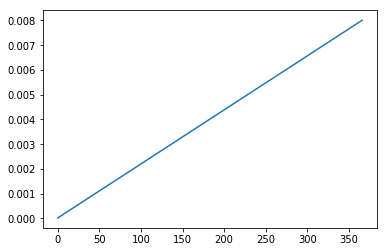

In [8]:
# First, calculate Rotational matrix between a and A 
from a3muse import IntegrationRK4, QuatToRotMat, quatNormalized, AccMagOrientation, QuatToEuler
from quaternionClass import QuaternionClass


print("In this purely rotational motion, gyroscope is experiencing: ", gz[0], "rad/s")

quat = QuaternionClass(1, 0, 0, 0)
omega0 = [gx[0], gy[0], gz[0]]
# omega0 = [0,0,0]
total_yaw = 0
qz = []
for i in range(len(gx)):
    omega1 = [gx[0], gy[0], gz[0]] 
#     omega1 = [0,0,0] 
    quatG = IntegrationRK4(omega0, omega1, quat, dt)
#     print(quatG[0], quatG[1], quatG[2], quatG[3])
    yaw,pitch,roll = QuatToEuler(quatG)
    total_yaw += yaw
    quat = quatG
    qz.append(quat[3])
#     print(yaw)
    omega0 = omega1

# 0.00174532924094 rad/s 
print(yaw)
print(0.00174532924094*dt*len(gz))
plt.plot(qz)


# Purely Translational Model

In [9]:

        
def EulerToQuat(yaw, pitch, roll):
    R = EulerToRotMat(yaw, pitch, roll)
    q = RotMatToQuat(R)
    return q 
def EulerToRotMat(yaw, pitch, roll):
    attitude = yaw # rotate about z 
    bank = roll # rotate about x 
    heading = pitch # rotate about y 
    sa = sin(attitude)
    ca = cos(attitude)
    sb = sin(bank)
    cb = cos(bank)
    sh = sin(heading)
    ch = cos(heading)

    m00 = ch*ca
    m01 = -ch*sa*cb + sh*sb
    m02 = ch*sa*sb + sh*cb
    m10 = sa
    m11 = ca*cb
    m12 = -ca*sb
    m20 = -sh*ca
    m21 = sh*sa*cb + ch*sb
    m22 = -sh*sa*sb + ch*cb

    R = np.array([[m00, m01, m02],[m10, m11, m12],[m20, m21, m22]])
    return R 


def RotMatToQuat(R):
    # https://afni.nimh.nih.gov/pub/dist/src/pkundu/meica.libs/nibabel/quaternions.py
    ''' Calculate quaternion corresponding to given rotation matrix

    Parameters
    ----------
    M : array-like
      3x3 rotation matrix

    Returns
    -------
    q : (4,) array
      closest quaternion to input matrix, having positive q[0]

    Notes
    -----
    Method claimed to be robust to numerical errors in M

    Constructs quaternion by calculating maximum eigenvector for matrix
    K (constructed from input `M`).  Although this is not tested, a
    maximum eigenvalue of 1 corresponds to a valid rotation.

    A quaternion q*-1 corresponds to the same rotation as q; thus the
    sign of the reconstructed quaternion is arbitrary, and we return
    quaternions with positive w (q[0]).

    References
    ----------
    * http://en.wikipedia.org/wiki/Rotation_matrix#Quaternion
    * Bar-Itzhack, Itzhack Y. (2000), "New method for extracting the
      quaternion from a rotation matrix", AIAA Journal of Guidance,
      Control and Dynamics 23(6):1085-1087 (Engineering Note), ISSN
      0731-5090

    Examples
    --------
    >>> import numpy as np
    >>> q = mat2quat(np.eye(3)) # Identity rotation
    >>> np.allclose(q, [1, 0, 0, 0])
    True
    >>> q = mat2quat(np.diag([1, -1, -1]))
    >>> np.allclose(q, [0, 1, 0, 0]) # 180 degree rotn around axis 0
    True

    '''
    # Qyx refers to the contribution of the y input vector component to
    # the x output vector component.  Qyx is therefore the same as
    # M[0,1].  The notation is from the Wikipedia article.

    m00 = R[0][0]
    m01 = R[0][1]
    m02 = R[0][2]
    m10 = R[1][0]
    m11 = R[1][1]
    m12 = R[1][2]
    m20 = R[2][0]
    m21 = R[2][1]
    m22 = R[2][2]

    Qxx = m00
    Qyx = m01
    Qzx = m02
    Qxy = m10
    Qyy = m11
    Qzy = m12
    Qxz = m20
    Qyz = m21
    Qzz = m22

    #Qxx, Qyx, Qzx, Qxy, Qyy, Qzy, Qxz, Qyz, Qzz = m00, m10, m20, 
    # Fill only lower half of symmetric matrix
    K = np.array([
        [Qxx - Qyy - Qzz, 0,               0,               0              ],
        [Qyx + Qxy,       Qyy - Qxx - Qzz, 0,               0              ],
        [Qzx + Qxz,       Qzy + Qyz,       Qzz - Qxx - Qyy, 0              ],
        [Qyz - Qzy,       Qzx - Qxz,       Qxy - Qyx,       Qxx + Qyy + Qzz]]
        ) / 3.0
    # Use Hermitian eigenvectors, values for speed
    vals, vecs = np.linalg.eigh(K)
    # Select largest eigenvector, reorder to w,x,y,z quaternion
    q = vecs[[3, 0, 1, 2], np.argmax(vals)]
    # Prefer quaternion with positive w
    # (q * -1 corresponds to same rotation as q)
    if q[0] < 0:
        q *= -1
    return q



In [10]:
def conj(q):
    return [q[0], -q[1], -q[2], -q[3]]

def to_euler_angles(self):
    pitch = np.arcsin(2 * self[1] * self[2] + 2 * self[0] * self[3])
    if np.abs(self[1] * self[2] + self[3] * self[0] - 0.5) < 1e-8:
        roll = 0
        yaw = 2 * np.arctan2(self[1], self[0])
    elif np.abs(self[1] * self[2] + self[3] * self[0] + 0.5) < 1e-8:
        roll = -2 * np.arctan2(self[1], self[0])
        yaw = 0
    else:
        roll = np.arctan2(2 * self[0] * self[1] - 2 * self[2] * self[3], 1 - 2 * self[1] ** 2 - 2 * self[3] ** 2)
        yaw = np.arctan2(2 * self[0] * self[2] - 2 * self[1] * self[3], 1 - 2 * self[2] ** 2 - 2 * self[3] ** 2)
    return roll, pitch, yaw

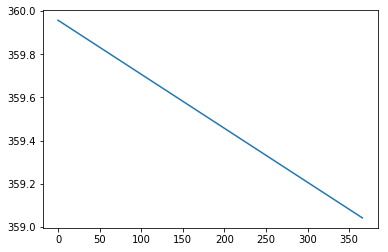

In [13]:
from math import atan
def headingfromMag(mag):
    mx = mag[0]
    my = mag[1]
    mz = mag[2]

    if my > 0 : 
        headingM = 90 - atan(mx/my)*180/math.pi
    if my < 0 : 
        headingM = 270 - atan(mx/my)*180/math.pi
    if my == 0:
        if mx < 0:
            headingM = 180.0
        else: 
            headingM = 0.0

    return headingM

head = []
for i in range(len(magx)):
    head.append(headingfromMag([magx[i],magy[i],magz[i]]))
plt.plot(head)
plt.show() 